In [1]:
import matplotlib.pyplot as plt
from pandas import set_option
import pandas as pd
import tensorflow.keras.utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, model_from_json, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, LSTM, Embedding
import numpy as np 
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn 
import tensorflow.keras
from tensorflow.keras import regularizers

from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import backend as K
import time as tm
import datetime
import os
from operator import itemgetter
from numpy import argmax

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)



In [2]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
set_option("display.max_rows", 15)
pd.options.mode.chained_assignment = None

#non-redundant InpactorDB
filename = '/home/bioml/Projects/PhD/InpactorDB/version_final/InpactorDB_non-redudant.fasta.kmers'
training_data = pd.read_csv(filename)

In [4]:
path_log_base = './logs'
# class dist|ribution
print(training_data.groupby('Label').size())
#1 for Copia and 2 for Gypsy

Label
1     12031
3      1458
4      1827
8        84
9      3556
12     6180
13     3130
14     2136
16      549
17     4532
18    10396
19     3499
20    17927
dtype: int64


In [5]:
label_vectors = training_data['Label'].values
feature_vectors = training_data.drop(['Label'], axis=1).values

In [6]:
# Scaling
scaler = preprocessing.StandardScaler().fit(feature_vectors)
feature_vectors_scaler = scaler.transform(feature_vectors)

In [7]:
print(label_vectors)

print(feature_vectors.shape)

[18 18 18 ... 12 18 12]
(67305, 5460)


In [8]:
#data split: 80% train, 10% dev and 10% test
validation_size = 0.2
seed = 7
X_trainScaler, X_test_dev, Y_train, Y_test_dev = train_test_split(feature_vectors_scaler, label_vectors, 
                                                                                        test_size=validation_size, 
                                                                                     random_state=seed)

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)


In [9]:
pca = decomposition.PCA(n_components=0.96,svd_solver='full',tol=1e-4)
pca.fit(X_trainScaler)
X_trainPCAScaler = pca.transform(X_trainScaler)
X_validationPCAScaler = pca.transform(X_dev)
X_testPCAScaler = pca.transform(X_test)

In [10]:
def metrics(Y_validation,predictions):
    print('Accuracy:', accuracy_score(Y_validation, predictions))
    print('F1 score:', f1_score(Y_validation, predictions,average='weighted'))
    print('Recall:', recall_score(Y_validation, predictions,average='weighted'))
    print('Precision:', precision_score(Y_validation, predictions, average='weighted'))
    print('\n clasification report:\n', classification_report(Y_validation, predictions))
    print('\n confusion matrix:\n',confusion_matrix(Y_validation, predictions))
    #Creamos la matriz de confusión
    num_classes = len(set(Y_validation))
    snn_cm = confusion_matrix(Y_validation, predictions)

    # Visualizamos la matriz de confusión
    snn_df_cm = pd.DataFrame(snn_cm, range(num_classes), range(num_classes))  
    plt.figure(figsize = (20,14))  
    sn.set(font_scale=1.4) #for label size  
    sn.heatmap(snn_df_cm, annot=True, annot_kws={"size": 12}) # font size  
    plt.show()

In [23]:
def graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID):
    numbers=AccTest
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Test F1-Score {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['f1_m']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Train F1-Score {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['val_f1_m']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Validation F1-Score {}, Época:{}\n".format(value, index+1))

    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 10))
        #Plot training & validation accuracy values
        plt.plot(np.concatenate([np.array([accuracyTRAIN]),np.array(history.history['f1_m'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyVALID]),np.array(history.history['val_f1_m'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyTEST]),np.array(AccTest)],axis=0)) #Test
        plt.ylim(0.50, 1)
        plt.title('F1-Score Vs Epoch')
        plt.ylabel('F1-Score')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        plt.savefig('/home/bioml/Projects/PhD/InpactorDB/gráficas/Nakano_25e_f1.eps', format='eps')
        plt.savefig('/home/bioml/Projects/PhD/InpactorDB/gráficas/Nakano_25e_f1.svg', format='svg')
        plt.savefig('/home/bioml/Projects/PhD/InpactorDB/gráficas/Nakano_25e_f1.pdf', format='pdf') 
        plt.savefig('/home/bioml/Projects/PhD/InpactorDB/gráficas/Nakano_25e_f1.png', format='png')
        #plt.show()
        
        plt.figure(figsize=(10, 10))
        #Plot training & validation loss values
        plt.plot(np.concatenate([np.array([lossTRAIN]),np.array(history.history['loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossVALID]),np.array(history.history['val_loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossTEST]),np.array(LossTest)],axis=0)) #Test
        #plt.ylim(0, 10)
        plt.title('Loss Vs Epoch')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        plt.savefig('/home/bioml/Projects/PhD/InpactorDB/gráficas/Nakano_25e_loss.eps', format='eps')
        plt.savefig('/home/bioml/Projects/PhD/InpactorDB/gráficas/Nakano_25e_loss.svg', format='svg')
        plt.savefig('/home/bioml/Projects/PhD/InpactorDB/gráficas/Nakano_25e_loss.pdf', format='pdf')
        plt.savefig('/home/bioml/Projects/PhD/InpactorDB/gráficas/Nakano_25e_loss.png', format='png') 
        plt.show() 

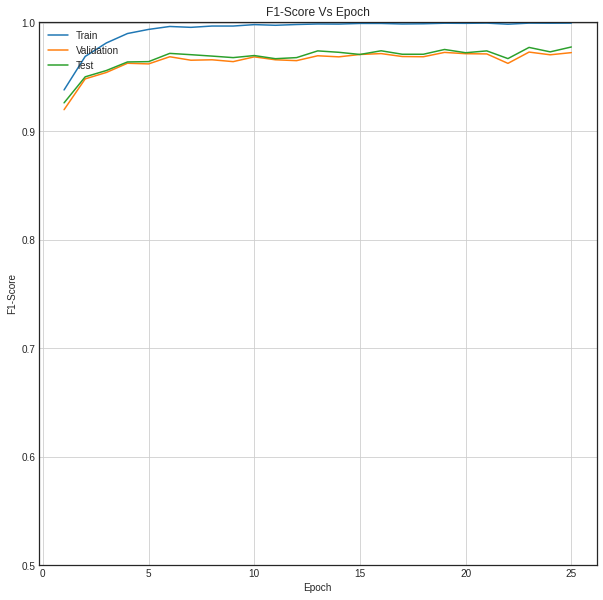

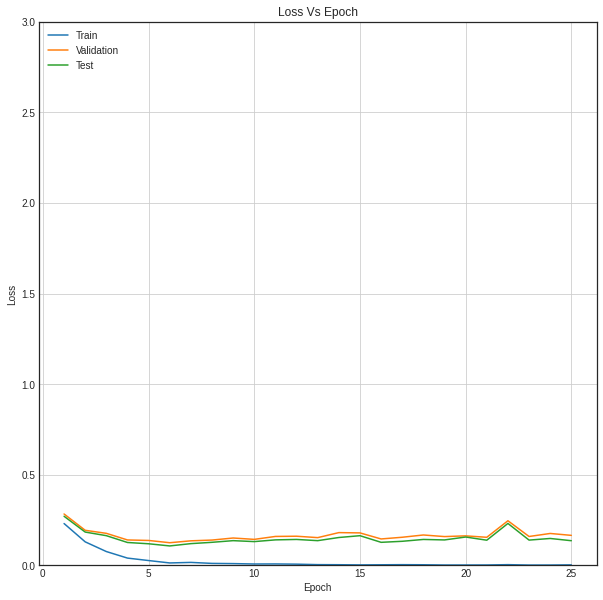

In [22]:
with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 10))
        #Plot training & validation accuracy values
        plt.plot(np.arange(1,26),np.array([0.9381, 0.9690, 0.9814, 0.9901, 0.9939, 0.9966, 0.9958, 0.9970, 0.9970, 0.9983, 0.9977, 0.9984, 0.9989, 0.9988, 0.9994, 0.9994, 0.9989, 0.9991, 0.9996, 0.9995, 0.9997, 0.9987, 0.9997, 0.9996, 0.9997]))
        plt.plot(np.arange(1,26),np.array([0.9199, 0.9483, 0.9542, 0.9627, 0.9621, 0.9687, 0.9655, 0.9659, 0.9642, 0.9686, 0.9659, 0.9651, 0.9696, 0.9686, 0.9708, 0.9716, 0.9689, 0.9687, 0.9727, 0.9715, 0.9713, 0.9626, 0.9730, 0.9705, 0.9725]))
        plt.plot(np.arange(1,26),np.array([0.9262, 0.9502, 0.9560, 0.9639, 0.9642, 0.9718, 0.9706, 0.9693, 0.9679, 0.9698, 0.9669, 0.9679, 0.9741, 0.9728, 0.9708, 0.9742, 0.9710, 0.9710, 0.9754, 0.9724, 0.9741, 0.9670, 0.9773, 0.9732, 0.9777])) #Test
        plt.ylim(0.50, 1.001)
        plt.title('F1-Score Vs Epoch')
        plt.ylabel('F1-Score')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        plt.savefig('/home/bioml/Projects/PhD/InpactorDB/gráficas/DeepTE_25e_f1.eps', format='eps')
        plt.savefig('/home/bioml/Projects/PhD/InpactorDB/gráficas/DeepTE_25e_f1.svg', format='svg')
        plt.savefig('/home/bioml/Projects/PhD/InpactorDB/gráficas/DeepTE_25e_f1.pdf', format='pdf')   
        plt.savefig('/home/bioml/Projects/PhD/InpactorDB/gráficas/DeepTE_25e_f1.png', format='png')
        #plt.show()
        
        plt.figure(figsize=(10, 10))
        #Plot training & validation loss values
        plt.plot(np.arange(1, 26),np.array([0.2305, 0.1294, 0.0759, 0.0398, 0.0262, 0.0130, 0.0160, 0.0105, 0.0094, 0.0072, 0.0075, 0.0063, 0.0037, 0.0032, 0.0022, 0.0029, 0.0035, 0.0030, 0.0016, 0.0016, 0.0018, 0.0036, 0.0014, 0.0015, 0.0024]))
        plt.plot(np.arange(1, 26),np.array([0.2832, 0.1932, 0.1764, 0.1399, 0.1371, 0.1246, 0.1351, 0.1393, 0.1506, 0.1431, 0.1593, 0.1605, 0.1527, 0.1804, 0.1788, 0.1454, 0.1548, 0.1673, 0.1585, 0.1625, 0.1546, 0.2458, 0.1590, 0.1757, 0.1652]))
        plt.plot(np.arange(1, 26),np.array([0.2706, 0.1834, 0.1635, 0.1259, 0.1188, 0.1069, 0.1196, 0.1269, 0.1360, 0.1308, 0.1403, 0.1427, 0.1360, 0.1534, 0.1634, 0.1268, 0.1325, 0.1427, 0.1400, 0.1561, 0.1385, 0.2310, 0.1391, 0.1481, 0.1357])) #Test
        plt.ylim(0, 3)
        plt.title('Loss Vs Epoch')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        plt.savefig('/home/bioml/Projects/PhD/InpactorDB/gráficas/DeepTE_25e_loss.eps', format='eps')
        plt.savefig('/home/bioml/Projects/PhD/InpactorDB/gráficas/DeepTE_25e_loss.svg', format='svg')
        plt.savefig('/home/bioml/Projects/PhD/InpactorDB/gráficas/DeepTE_25e_loss.pdf', format='pdf') 
        plt.savefig('/home/bioml/Projects/PhD/InpactorDB/gráficas/DeepTE_25e_loss.png', format='png')
        plt.show() 

In [30]:
len(np.array([0.9381, 0.9690, 0.9814, 0.9901, 0.9939, 0.9966, 0.9958, 0.9970, 0.9970, 0.9983, 0.9977, 0.9984, 0.9989, 0.9988, 0.9994, 0.9994, 0.9989, 0.9991, 0.9996, 0.9995, 0.9997, 0.9987, 0.9997, 0.9996]))

24

In [14]:
def Final_Results_Test(PATH_trained_models, X_test, Y_test):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= [] 
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model = tf.keras.models.load_model(PATH_trained_models+'/'+filename, custom_objects={'f1_m':f1_m})
            loss,accuracy = model.evaluate(X_test, Y_test,verbose=0)
            print(f'Loss={loss:.4f} and F1-score={accuracy:0.4f}'+'\n')
            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)    #Valores de la precisión en Test, para graficar junto a valid y train
            LossTest.append(BandLossTest)  #Valores de la perdida en Test, para graficar junto a valid y train
            
            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename
    
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y Accuracy={B_accuracy:0.4f}'+'\n')

In [15]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, model_name=""):
    start_time = tm.time()
    log_dir=path_log_base+"/"+model_name+"_"+str(datetime.datetime.now().isoformat()[:19].replace("T", "_").replace(":","-"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir+"/saved-model-{epoch:03d}-{val_f1_m:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_f1_m', save_best_only=False, mode='max')
    model.reset_states()
    
    #VALORES EN TRAIN TEST Y VALIDACIÓN INICIALES, GRÁFICOS
    global lossTEST
    global accuracyTEST
    global lossTRAIN
    global accuracyTRAIN
    global lossVALID
    global accuracyVALID
    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    
    global history
    global model_Name
    global log_Dir
    model_Name = model_name
    log_Dir = log_dir
    
    history=model.fit(X_train, y_train, epochs=epochs, 
                      callbacks=[tensorboard,checkpoint], 
                      batch_size=batch_size,validation_data=(X_valid, y_valid),verbose=1)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
     
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    
    print("\n")
    print(log_dir)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [ ]:
# Implementing DeepTE published by Yan et al. (2020)
def DeepTE():
    tf.keras.backend.clear_session()

    # FNN implemented by Nakano

    #Inputs
    inputs = tf.keras.Input(shape=(X_trainPCAScaler.shape[1],1), name="input_1")
    #layer 1
    layers = tf.keras.layers.Conv1D(100, kernel_size=3, strides = 1, activation='relu')(inputs)
    layers = tf.keras.layers.MaxPooling1D(pool_size=2, strides=1)(layers)
    #layer 2
    layers = tf.keras.layers.Conv1D(150, kernel_size=3, strides = 1, activation='relu')(layers)
    layers = tf.keras.layers.MaxPooling1D(pool_size=2, strides=1)(layers)
    #layer 3
    layers = tf.keras.layers.Conv1D(225, kernel_size=3, strides = 1, activation='relu')(layers)
    layers = tf.keras.layers.MaxPooling1D(pool_size=2, strides=1)(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(128,activation="relu")(layers)    
    # layer 4
    layers = tf.keras.layers.Dropout(0.5)(layers)
    predictions = tf.keras.layers.Dense(21, activation="softmax", name="output_1")(layers)
    # model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    # optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    # loss function
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    # Compile model
    model.compile(loss=loss_fn, optimizer=opt, metrics=f1_m)
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2261, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2259, 100)         400       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2258, 100)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2256, 150)         45150     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2255, 150)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2253, 225)         101475    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2252, 225)         0     

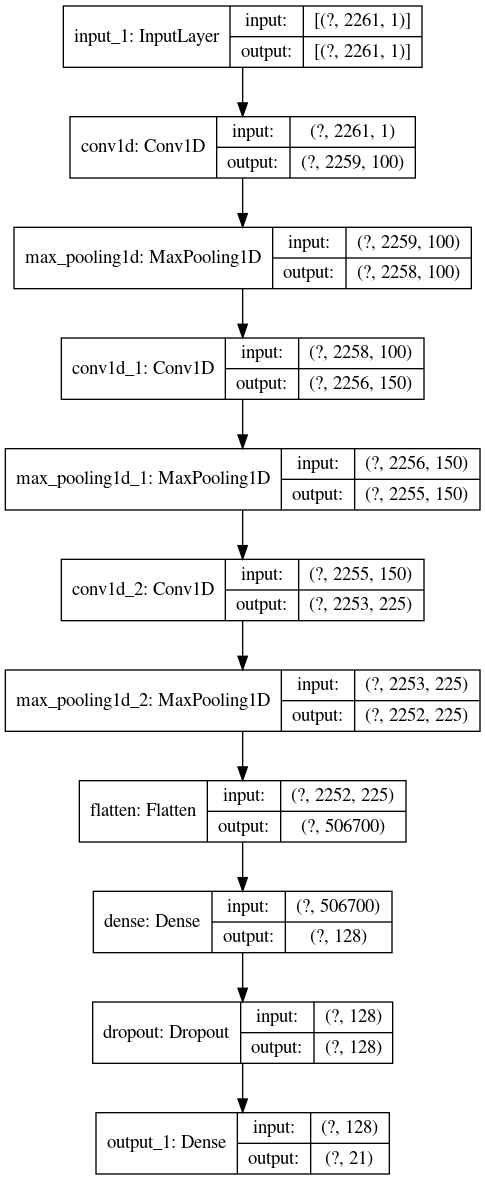

In [20]:
# baseline Nakano et al (2018) architecture 
model = DeepTE()
# summarize layers
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

In [10]:
one_hot_labels_train = tf.keras.utils.to_categorical(Y_train, num_classes=21)
one_hot_labels_validation = tf.keras.utils.to_categorical(Y_dev, num_classes=21)
one_hot_labels_test = tf.keras.utils.to_categorical(Y_test, num_classes=21)

In [39]:
# Fit the model
#train(model, X_trainPCAScaler, one_hot_labels_train, X_validationPCAScaler, one_hot_labels_validation, X_testPCAScaler, one_hot_labels_test, 128, 200, "DeepTE")
Final_Results_Test(log_Dir, X_testPCAScaler, one_hot_labels_test) 

saved-model-001-0.9204.hdf5
Loss=0.2706 and F1-score=0.9262

saved-model-002-0.9486.hdf5
Loss=0.1834 and F1-score=0.9502

saved-model-003-0.9546.hdf5
Loss=0.1635 and F1-score=0.9560

saved-model-004-0.9628.hdf5
Loss=0.1259 and F1-score=0.9639

saved-model-005-0.9623.hdf5
Loss=0.1188 and F1-score=0.9642

saved-model-006-0.9687.hdf5


ResourceExhaustedError: OOM when allocating tensor with shape[506700,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul]

In [12]:
f1_train = []
loss_train = []
f1_val = []
loss_val= []
f1_test = []
loss_test = []
models = sorted(os.listdir("logs/DeepTE_2020-11-12_15-06-02/"))[24]
for m in models:
        if m != ('train') and m != ('validation'):
            print(m)
            model = tf.keras.models.load_model("logs/DeepTE_2020-11-12_15-06-02"+'/'+m, custom_objects={'f1_m':f1_m})
            loss,accuracy = model.evaluate(X_trainPCAScaler, one_hot_labels_train,verbose=0)
            f1_train.append(accuracy)
            loss_train.append(loss)
            print(f'Training Loss={loss:.4f} and F1-score={accuracy:0.4f}'+'\n')
            loss,accuracy = model.evaluate(X_validationPCAScaler, one_hot_labels_validation,verbose=0)
            f1_val.append(accuracy)
            loss_val.append(loss)
            print(f'Validation Loss={loss:.4f} and F1-score={accuracy:0.4f}'+'\n')
            loss,accuracy = model.evaluate(X_testPCAScaler, one_hot_labels_test,verbose=0)
            f1_test.append(accuracy)
            loss_test.append(loss)
            print(f'Test Loss={loss:.4f} and F1-score={accuracy:0.4f}'+'\n')

saved-model-010-0.9686.hdf5
Training Loss=0.0072 and F1-score=0.9983

Validation Loss=0.1431 and F1-score=0.9686

Test Loss=0.1308 and F1-score=0.9698



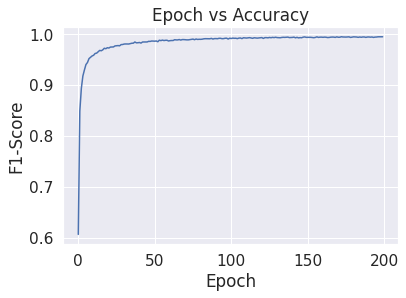


Train F1-Score 0.994964063167572, Época:173

Train F1-Score 0.994890570640564, Época:200

Train F1-Score 0.9948548674583435, Época:197

Train F1-Score 0.9948267340660095, Época:198

Train F1-Score 0.9947707056999207, Época:178

Train F1-Score 0.9947617650032043, Época:181

Train F1-Score 0.9947616457939148, Época:157

Train F1-Score 0.9947342872619629, Época:170

Train F1-Score 0.9947106242179871, Época:199

Train F1-Score 0.9946075677871704, Época:149


Validation F1-Score 0.97352534532547, Época:87

Validation F1-Score 0.9732720851898193, Época:106

Validation F1-Score 0.9731374979019165, Época:24

Validation F1-Score 0.9729426503181458, Época:80

Validation F1-Score 0.9728906750679016, Época:19

Validation F1-Score 0.9728338718414307, Época:101

Validation F1-Score 0.9724888801574707, Época:27

Validation F1-Score 0.9724245667457581, Época:59

Validation F1-Score 0.9721378684043884, Época:177

Validation F1-Score 0.9721165895462036, Época:105



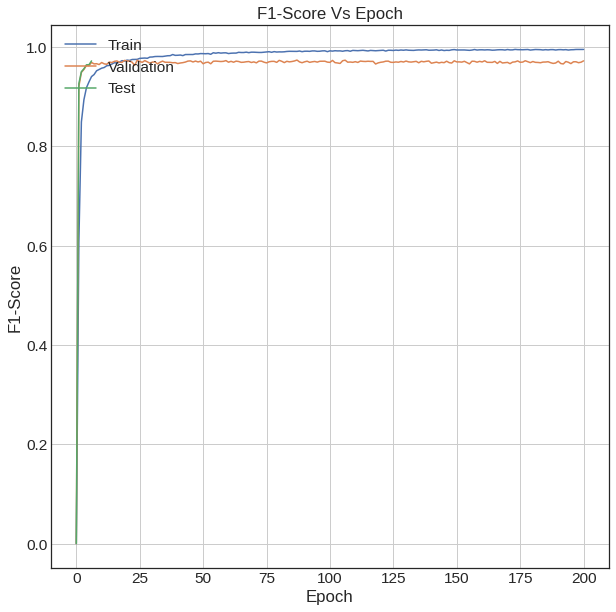

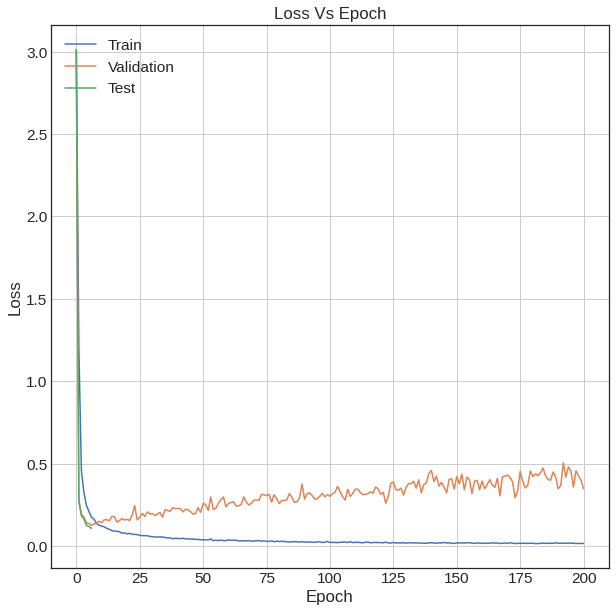

In [23]:
# plot metrics
plt.plot(history.history['f1_m'])
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Epoch vs Accuracy')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)

Baseline Error train: 0.00%
Baseline Error dev: 2.80%
Baseline Error test: 2.43%
Accuracy: 0.9999814278285417
F1 score: 0.9999814300349683
Recall: 0.9999814278285417
Precision: 0.9999814403603713

 clasification report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00      9563
           3       1.00      1.00      1.00      1158
           4       1.00      1.00      1.00      1481
           8       1.00      1.00      1.00        71
           9       1.00      1.00      1.00      2896
          12       1.00      1.00      1.00      5006
          13       1.00      1.00      1.00      2465
          14       1.00      1.00      1.00      1717
          16       1.00      1.00      1.00       434
          17       1.00      1.00      1.00      3605
          18       1.00      1.00      1.00      8282
          19       1.00      1.00      1.00      2765
          20       1.00      1.00      1.00     14401

    accuracy         

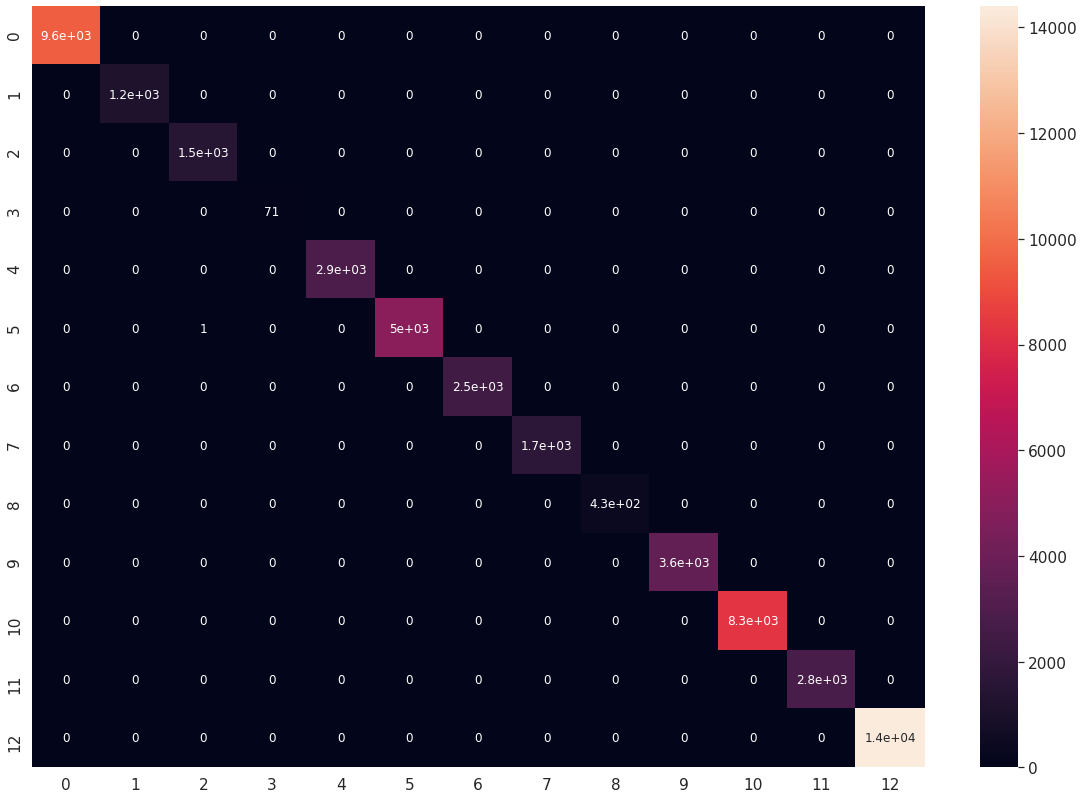

Accuracy: 0.9719167904903417
F1 score: 0.9715290590039738
Recall: 0.9719167904903417
Precision: 0.9718669763480485

 clasification report:
               precision    recall  f1-score   support

           1       0.96      0.98      0.97      1248
           3       0.99      0.97      0.98       155
           4       1.00      0.97      0.98       180
           8       0.67      0.33      0.44         6
           9       0.96      0.94      0.95       341
          12       0.94      0.94      0.94       599
          13       0.98      0.98      0.98       340
          14       0.96      0.88      0.92       218
          16       0.98      0.70      0.82        57
          17       0.95      0.98      0.97       430
          18       0.98      0.98      0.98      1055
          19       0.97      0.95      0.96       362
          20       0.99      1.00      0.99      1739

    accuracy                           0.97      6730
   macro avg       0.95      0.89      0.91     

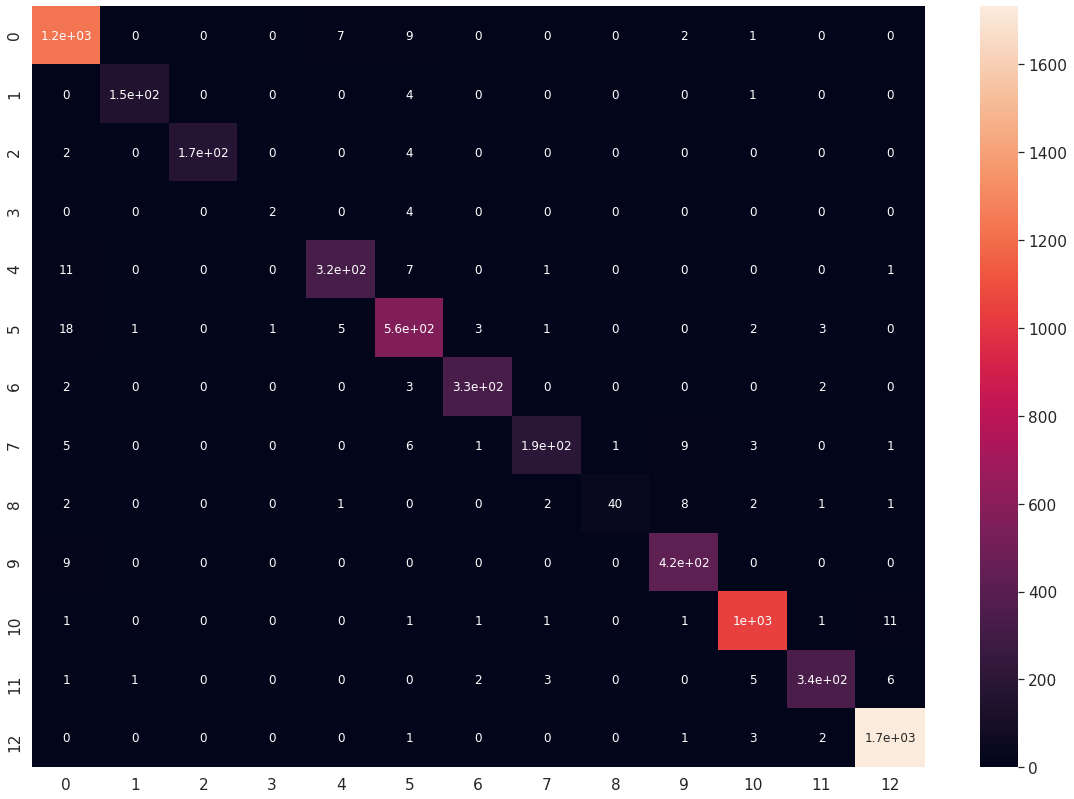

Accuracy: 0.9754865547466944
F1 score: 0.9751386850326054
Recall: 0.9754865547466944
Precision: 0.9755677085012403

 clasification report:
               precision    recall  f1-score   support

           1       0.97      0.99      0.98      1220
           3       0.96      0.94      0.95       145
           4       1.00      0.95      0.98       166
           8       1.00      0.43      0.60         7
           9       0.96      0.93      0.95       319
          12       0.94      0.94      0.94       575
          13       0.99      0.97      0.98       325
          14       0.97      0.92      0.94       201
          16       1.00      0.74      0.85        58
          17       0.98      0.99      0.98       497
          18       0.98      0.98      0.98      1059
          19       0.97      0.99      0.98       372
          20       0.99      1.00      0.99      1787

    accuracy                           0.98      6731
   macro avg       0.98      0.91      0.93     

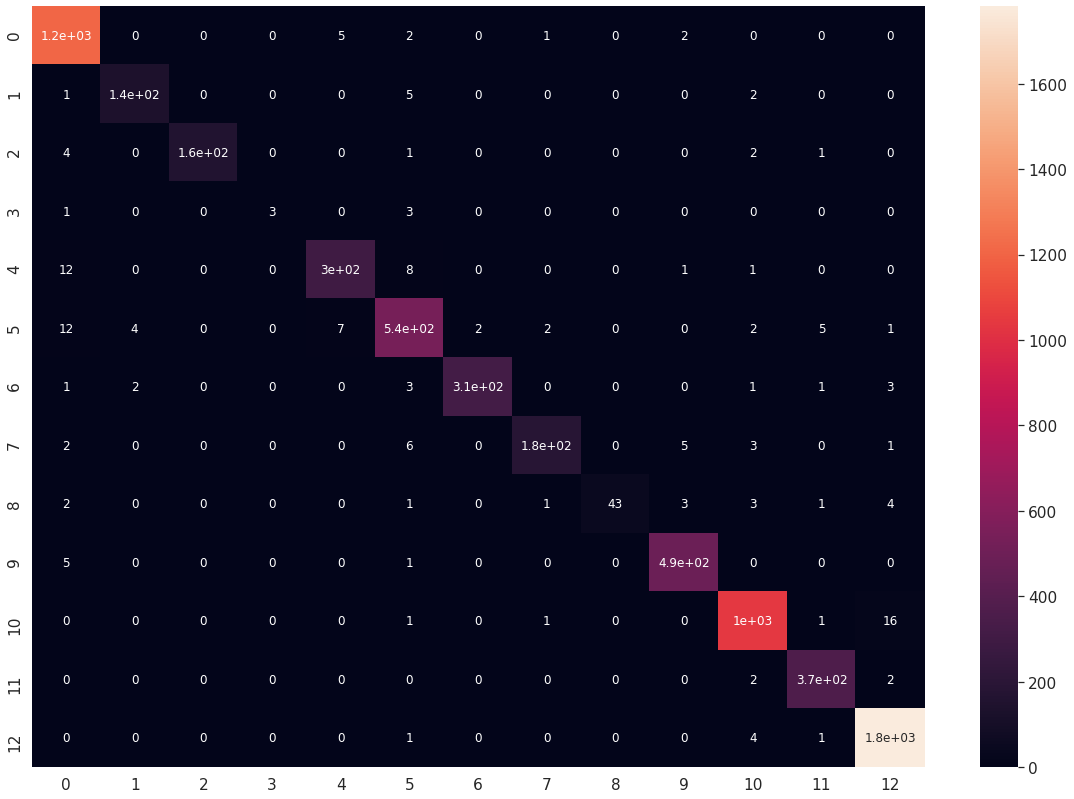

In [25]:
scores = model.evaluate(X_trainPCAScaler, one_hot_labels_train, verbose=0)
print("Baseline Error train: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_validationPCAScaler, one_hot_labels_validation, verbose=0)
print("Baseline Error dev: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_testPCAScaler, one_hot_labels_test, verbose=0)
print("Baseline Error test: %.2f%%" % (100-scores[1]*100))

predictions = model.predict(X_trainPCAScaler)

metrics(Y_train, [argmax(x) for x in predictions])

predictions = model.predict(X_validationPCAScaler)

metrics(Y_dev, [argmax(x) for x in predictions])

predictions = model.predict(X_testPCAScaler)

metrics(Y_test, [argmax(x) for x in predictions])

In [ ]:
# generalization test
# load Gardenia jasminoides data
filename = "/home/bioml/Projects/PhD/InpactorDB/version_final/Generalization_test/Gardenia_jasminoides.fasta.kmers"
gen_data = pd.read_csv(filename)
label_vectors_gen = gen_data['Label'].values
feature_vectors_gen = gen_data.drop(['Label'], axis=1).values
feature_vectors_scaler = scaler.transform(feature_vectors_gen)
X_gen_pca_scaling = pca.transform(feature_vectors_scaler)

Accuracy: 0.8841584158415842
F1 score: 0.8654641821796091
Recall: 0.8841584158415842
Precision: 0.8988026660650542

 clasification report:
               precision    recall  f1-score   support

           1       0.85      0.99      0.91       100
           3       1.00      0.33      0.49        80
           4       1.00      0.92      0.96        39
           9       0.89      0.19      0.31        42
          12       0.72      0.90      0.80       109
          13       0.99      1.00      0.99       167
          14       0.99      1.00      1.00       110
          17       1.00      1.00      1.00        60
          18       0.79      0.92      0.85       163
          19       0.95      1.00      0.97        92
          20       0.81      0.98      0.89        48

    accuracy                           0.88      1010
   macro avg       0.91      0.84      0.83      1010
weighted avg       0.90      0.88      0.87      1010


 confusion matrix:
 [[ 99   0   0   0   1   0 

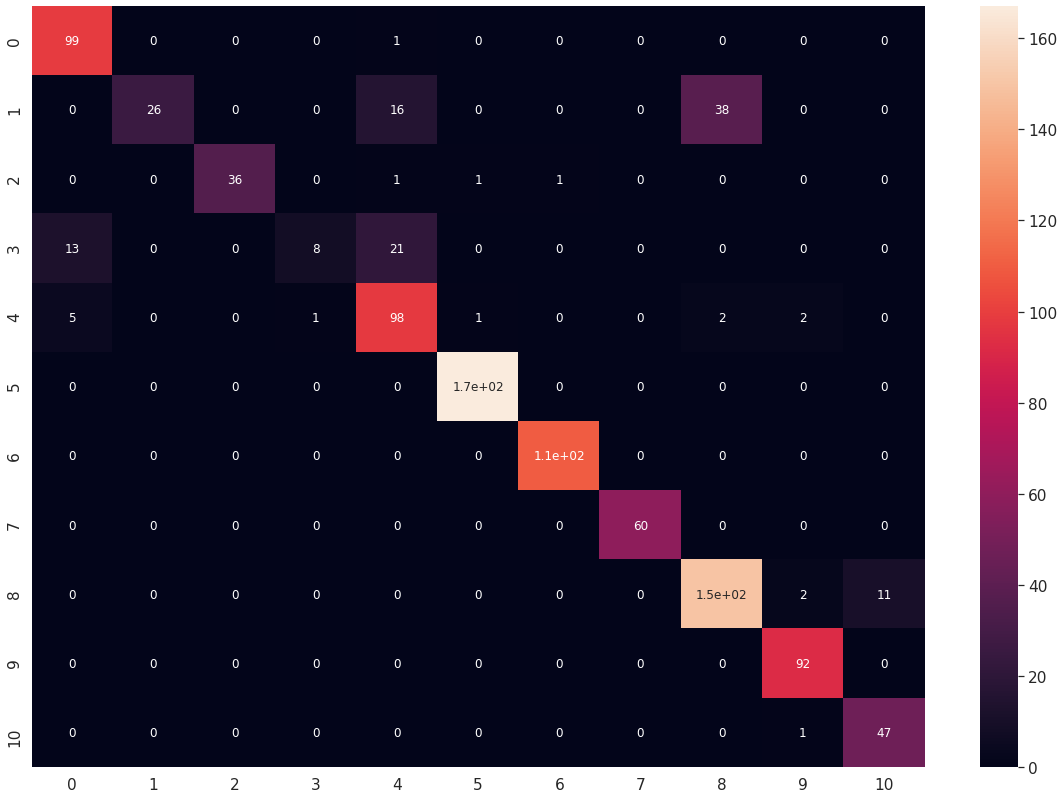

In [26]:
#load the trained model
#model = tf.keras.models.load_model('logs/', custom_objects={'f1_m':f1_m})
predictions = model.predict(X_gen_pca_scaling)

metrics(label_vectors_gen, [argmax(x) for x in predictions])

In [11]:
# implementing FNN published by Nakano et al (2018)
def Nakano_Net():
    tf.keras.backend.clear_session()

    # FNN implemented by Nakano

    #Inputs
    inputs = tf.keras.Input(shape=(X_trainPCAScaler.shape[1],), name="input_1")
    #layer 1
    layers = tf.keras.layers.Dense(200,activation="relu")(inputs)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    #layer 2
    layers = tf.keras.layers.Dense(200,activation="relu")(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    #layer 3
    layers = tf.keras.layers.Dense(200,activation="relu")(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    # layer 4
    predictions = tf.keras.layers.Dense(21, activation="softmax", name="output_1")(layers)
    # model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    # optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,)
    # loss function
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    # Compile model
    model.compile(loss=loss_fn, optimizer=opt, metrics=f1_m)
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2261)]            0         
_________________________________________________________________
dense (Dense)                (None, 200)               452400    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0     

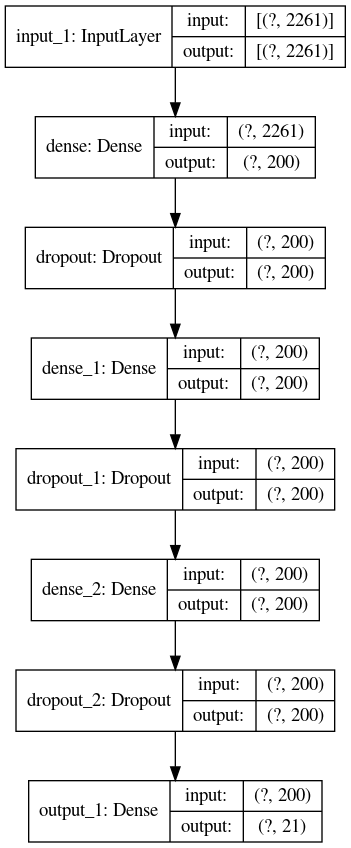

In [12]:
model = Nakano_Net()
# summarize layers
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

In [16]:
# Fit the model
train(model, X_trainPCAScaler, one_hot_labels_train, X_validationPCAScaler, one_hot_labels_validation, X_testPCAScaler, one_hot_labels_test, 128, 25, "Nakano1")
Final_Results_Test(log_Dir, X_testPCAScaler, one_hot_labels_test) 

Epoch 1/25
421/421 [==============================] - 1s 3ms/step - loss: 0.3645 - f1_m: 0.8811 - val_loss: 0.0860 - val_f1_m: 0.9749
Epoch 2/25
421/421 [==============================] - 1s 3ms/step - loss: 0.0668 - f1_m: 0.9805 - val_loss: 0.0723 - val_f1_m: 0.9812
Epoch 3/25
421/421 [==============================] - 1s 3ms/step - loss: 0.0376 - f1_m: 0.9889 - val_loss: 0.0848 - val_f1_m: 0.9794
Epoch 4/25
421/421 [==============================] - 1s 3ms/step - loss: 0.0290 - f1_m: 0.9910 - val_loss: 0.0846 - val_f1_m: 0.9805
Epoch 5/25
421/421 [==============================] - 1s 3ms/step - loss: 0.0240 - f1_m: 0.9920 - val_loss: 0.0952 - val_f1_m: 0.9801
Epoch 6/25
421/421 [==============================] - 1s 3ms/step - loss: 0.0196 - f1_m: 0.9942 - val_loss: 0.0954 - val_f1_m: 0.9790
Epoch 7/25
421/421 [==============================] - 1s 3ms/step - loss: 0.0199 - f1_m: 0.9943 - val_loss: 0.0909 - val_f1_m: 0.9804
Epoch 8/25
421/421 [==============================] - 1s 3ms/s

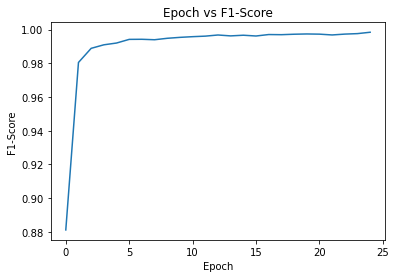

Test F1-Score 0.9864989519119263, Época:14


Train F1-Score 0.9984307289123535, Época:25


Validation F1-Score 0.9838367700576782, Época:12



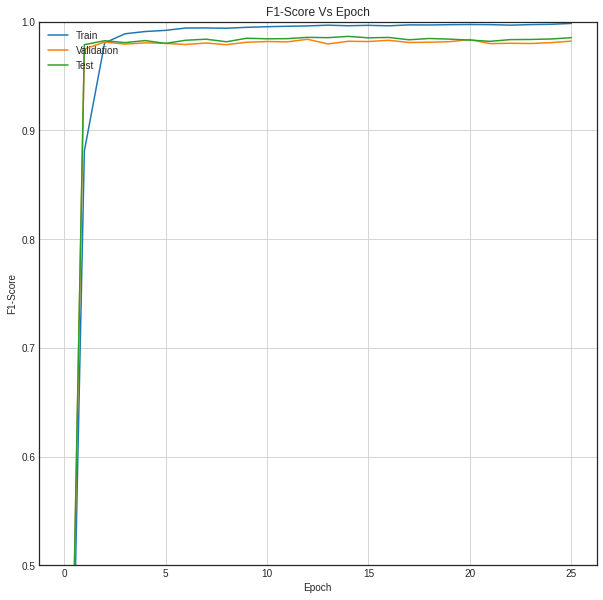

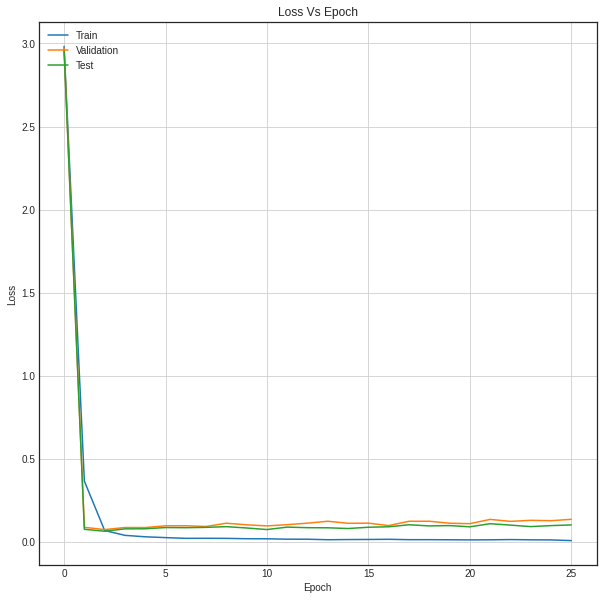

In [24]:
# plot metrics
plt.plot(history.history['f1_m'])
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Epoch vs F1-Score')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)

Baseline Error train: 0.01%
Baseline Error dev: 1.56%
Baseline Error test: 1.49%
Accuracy: 0.9998885669712503
F1 score: 0.9998885607963265
Recall: 0.9998885669712503
Precision: 0.9998886038875578

 clasification report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00      9563
           3       1.00      1.00      1.00      1158
           4       1.00      1.00      1.00      1481
           8       1.00      1.00      1.00        71
           9       1.00      1.00      1.00      2896
          12       1.00      1.00      1.00      5006
          13       1.00      1.00      1.00      2465
          14       1.00      1.00      1.00      1717
          16       1.00      1.00      1.00       434
          17       1.00      1.00      1.00      3605
          18       1.00      1.00      1.00      8282
          19       1.00      1.00      1.00      2765
          20       1.00      1.00      1.00     14401

    accuracy         

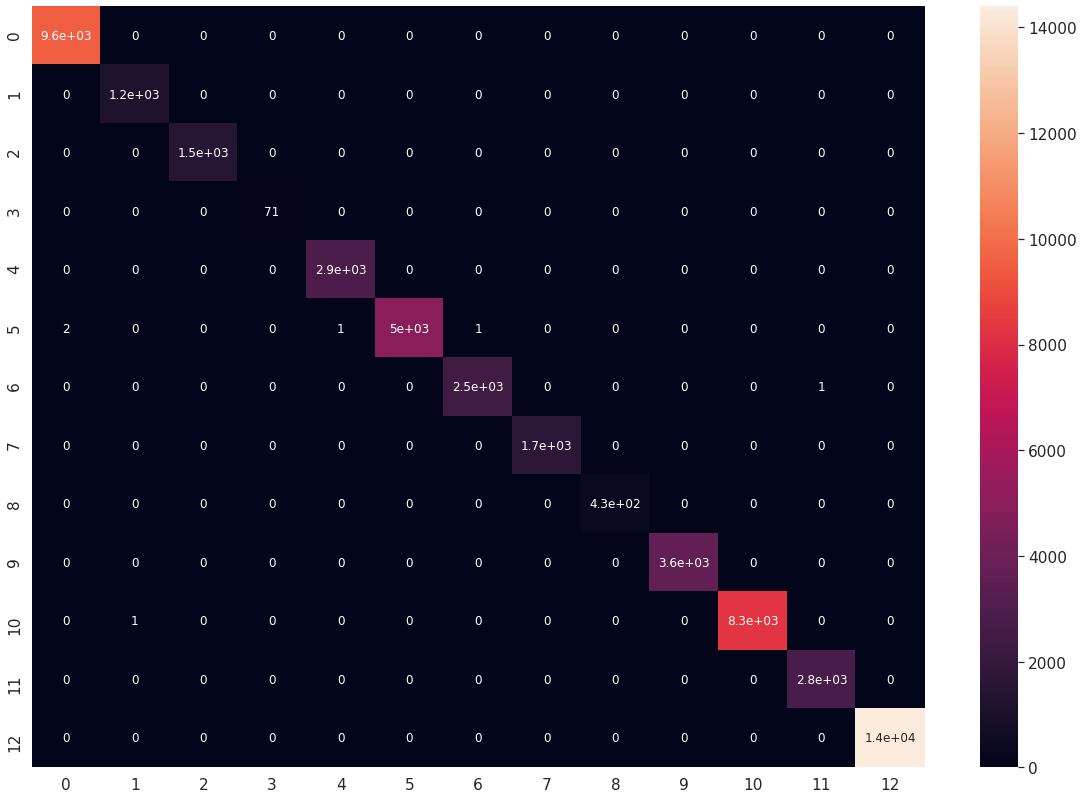

Accuracy: 0.9845468053491828
F1 score: 0.9844742413577534
Recall: 0.9845468053491828
Precision: 0.9844945285446147

 clasification report:
               precision    recall  f1-score   support

           1       0.99      0.99      0.99      1248
           3       0.98      0.98      0.98       155
           4       1.00      0.99      1.00       180
           8       0.60      0.50      0.55         6
           9       0.96      0.99      0.97       341
          12       0.98      0.96      0.97       599
          13       0.98      0.99      0.99       340
          14       0.97      0.95      0.96       218
          16       0.98      0.89      0.94        57
          17       0.98      0.99      0.99       430
          18       0.99      0.99      0.99      1055
          19       0.98      0.97      0.98       362
          20       0.99      0.99      0.99      1739

    accuracy                           0.98      6730
   macro avg       0.95      0.94      0.94     

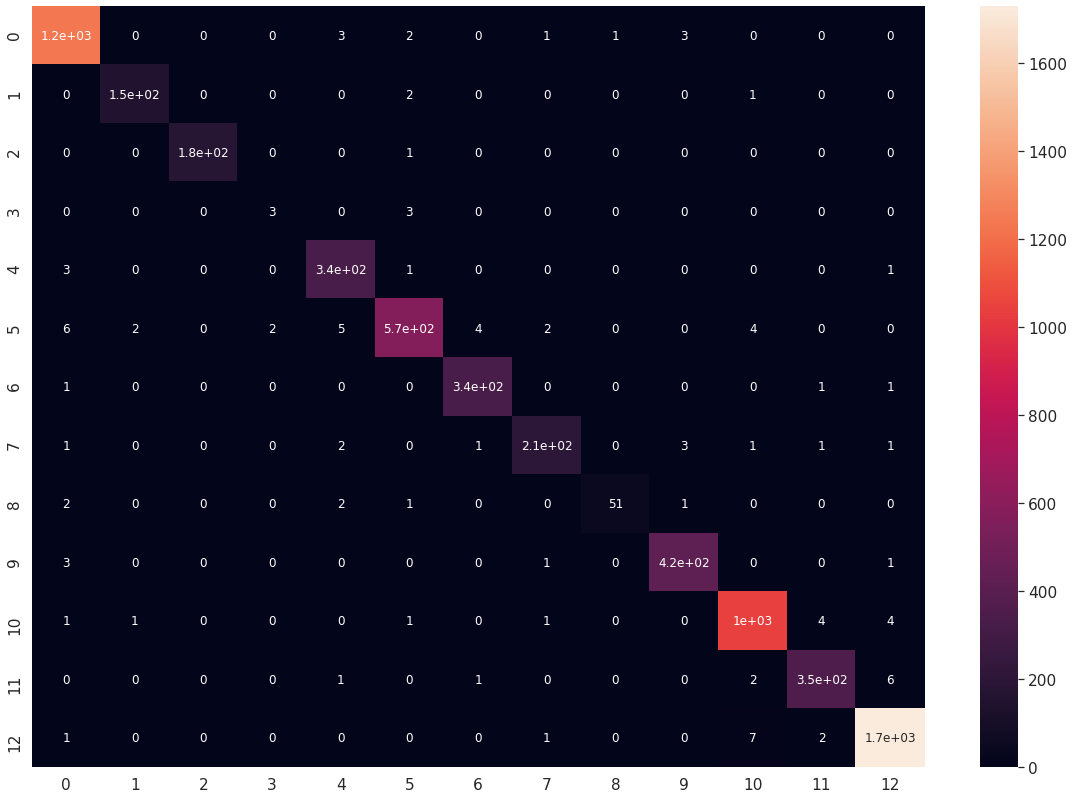

Accuracy: 0.9848462338434111
F1 score: 0.9848081220565044
Recall: 0.9848462338434111
Precision: 0.984847208288327

 clasification report:
               precision    recall  f1-score   support

           1       0.99      0.99      0.99      1220
           3       0.96      0.98      0.97       145
           4       0.99      0.99      0.99       166
           8       0.67      0.57      0.62         7
           9       0.95      0.97      0.96       319
          12       0.98      0.95      0.96       575
          13       0.99      0.98      0.99       325
          14       0.98      0.97      0.97       201
          16       1.00      0.93      0.96        58
          17       0.99      1.00      0.99       497
          18       0.99      0.99      0.99      1059
          19       0.97      0.98      0.97       372
          20       0.99      0.99      0.99      1787

    accuracy                           0.98      6731
   macro avg       0.96      0.95      0.95      

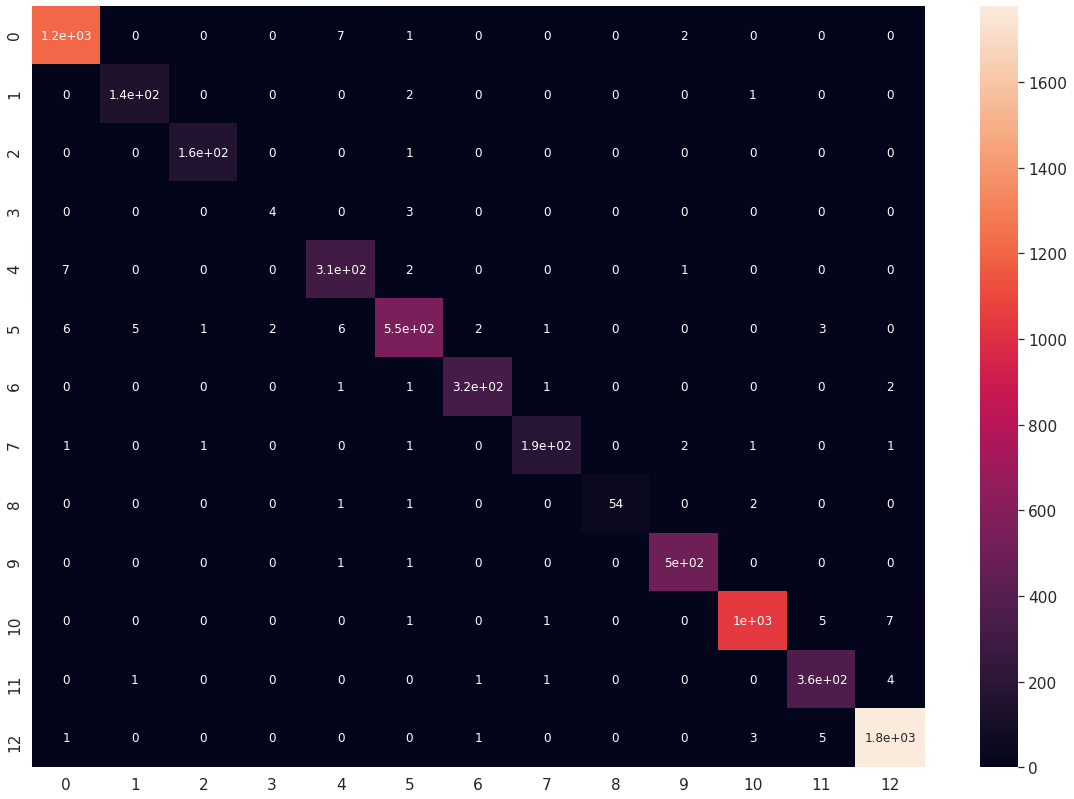

In [21]:
scores = model.evaluate(X_trainPCAScaler, one_hot_labels_train, verbose=0)
print("Baseline Error train: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_validationPCAScaler, one_hot_labels_validation, verbose=0)
print("Baseline Error dev: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_testPCAScaler, one_hot_labels_test, verbose=0)
print("Baseline Error test: %.2f%%" % (100-scores[1]*100))

predictions = model.predict(X_trainPCAScaler)

metrics(Y_train, [argmax(x) for x in predictions])

predictions = model.predict(X_validationPCAScaler)

metrics(Y_dev, [argmax(x) for x in predictions])

predictions = model.predict(X_testPCAScaler)

metrics(Y_test, [argmax(x) for x in predictions])

In [18]:
# generalization test
# load Gardenia jasminoides data
filename = "/home/bioml/Projects/PhD/InpactorDB/version_final/Generalization_test/Gardenia_jasminoides.fasta.kmers"
gen_data = pd.read_csv(filename)
label_vectors_gen = gen_data['Label'].values
feature_vectors_gen = gen_data.drop(['Label'], axis=1).values
feature_vectors_scaler = scaler.transform(feature_vectors_gen)
X_gen_pca_scaling = pca.transform(feature_vectors_scaler)

Accuracy: 0.9792079207920792
F1 score: 0.978924626256808
Recall: 0.9792079207920792
Precision: 0.9802244108186888

 clasification report:
               precision    recall  f1-score   support

           1       0.93      1.00      0.97       100
           3       1.00      0.88      0.93        80
           4       1.00      1.00      1.00        39
           9       1.00      0.86      0.92        42
          12       0.93      0.99      0.96       109
          13       0.99      1.00      1.00       167
          14       1.00      0.99      1.00       110
          17       1.00      1.00      1.00        60
          18       0.98      0.98      0.98       163
          19       1.00      1.00      1.00        92
          20       0.96      1.00      0.98        48

    accuracy                           0.98      1010
   macro avg       0.98      0.97      0.98      1010
weighted avg       0.98      0.98      0.98      1010


 confusion matrix:
 [[100   0   0   0   0   0  

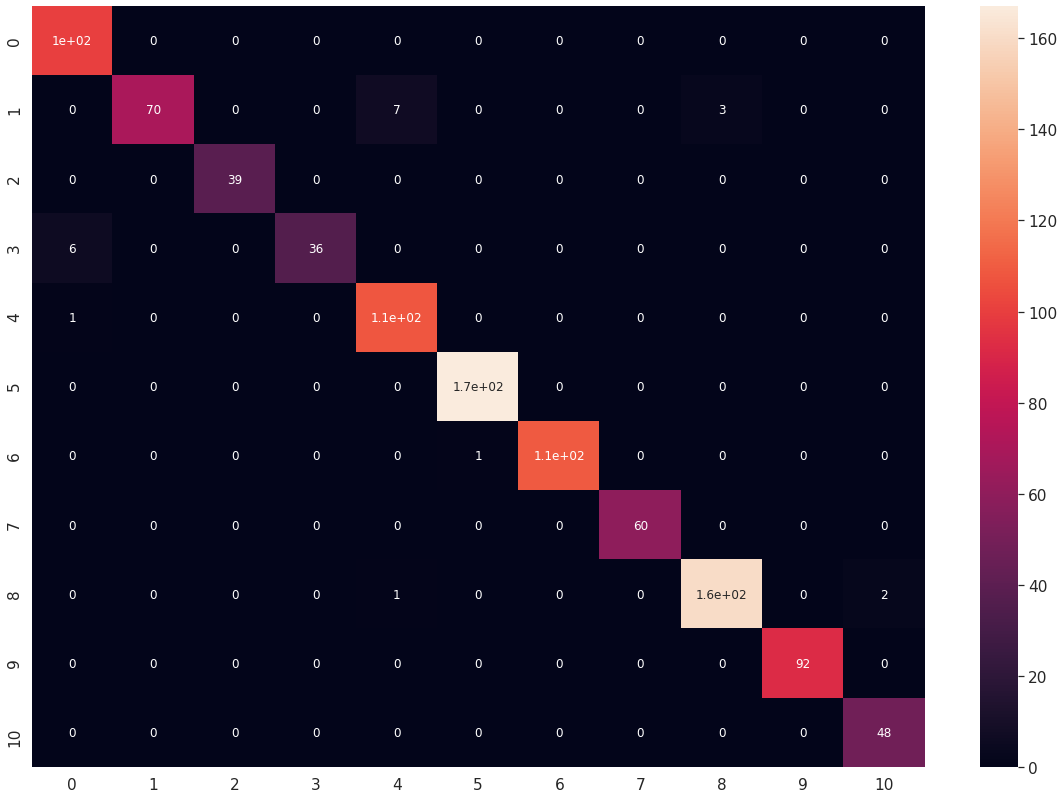

In [19]:
#load the trained model
model = tf.keras.models.load_model('logs/Nakano1_2020-11-12_14-32-59/saved-model-159-0.9827.hdf5', custom_objects={'f1_m':f1_m})
predictions = model.predict(X_gen_pca_scaling)

metrics(label_vectors_gen, [argmax(x) for x in predictions])